In [5]:
import pandas as pd

results = pd.read_csv("csv/results.csv")
sprint = pd.read_csv("csv/sprint_results.csv")
drivers = pd.read_csv("csv/drivers.csv")
pitstops = pd.read_csv("csv/pit_stops.csv")
qualy = pd.read_csv("csv/qualifying.csv")
sprints = pd.read_csv("csv/sprint_results.csv")


DRIVER PERFORMANCE BY TRACK TYPE ANALYSIS
Analyzing 26519 race results across 77 circuits

Track type distribution:
  Other Tracks: 10258 races
  High-Speed Tracks: 6267 races
  Technical Tracks: 4699 races
  Street Circuits: 3155 races
  Modern Tilke Tracks: 2140 races

Focusing on recent years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Recent data: 1899 race results

ANALYSIS 1: WIN RATE BY TRACK TYPE


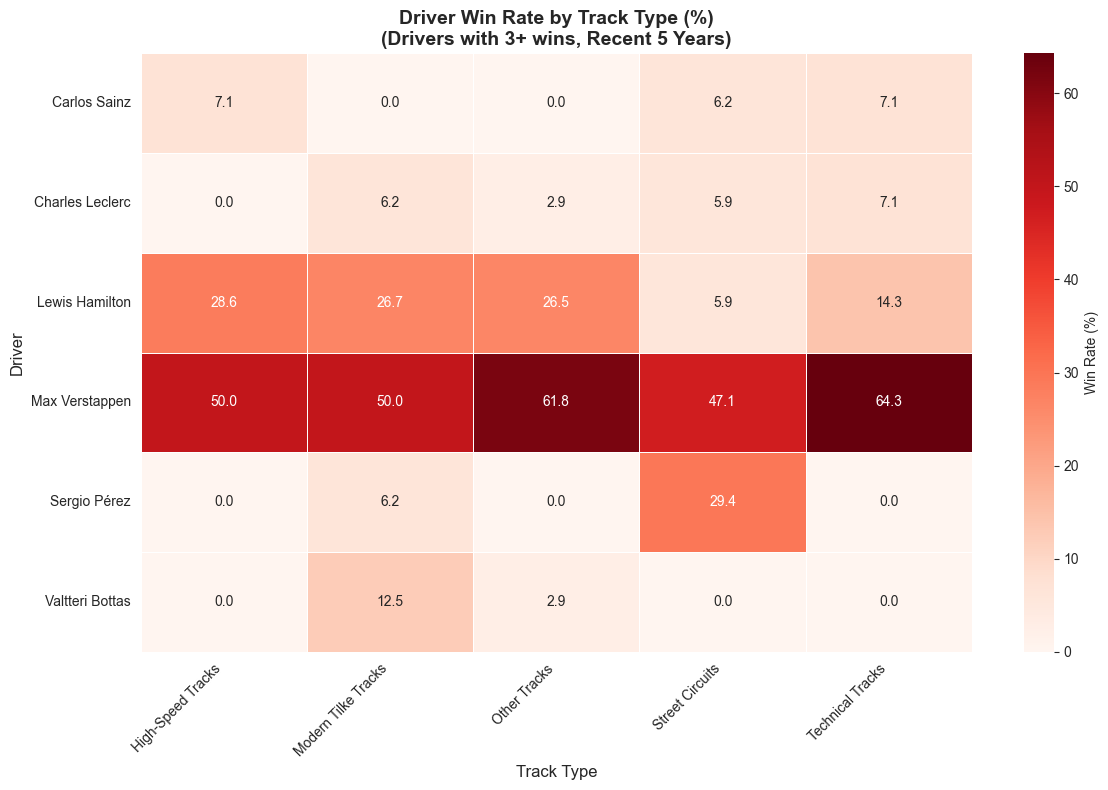


TOP PERFORMERS BY TRACK TYPE:
----------------------------------------
High-Speed Tracks:
  Best: Max Verstappen (50.0% win rate, 7 wins)
Modern Tilke Tracks:
  Best: Max Verstappen (50.0% win rate, 8 wins)
Other Tracks:
  Best: Max Verstappen (61.8% win rate, 21 wins)
Street Circuits:
  Best: Max Verstappen (47.1% win rate, 8 wins)
Technical Tracks:
  Best: Max Verstappen (64.3% win rate, 9 wins)

ANALYSIS 2: AVERAGE FINISHING POSITION BY TRACK TYPE


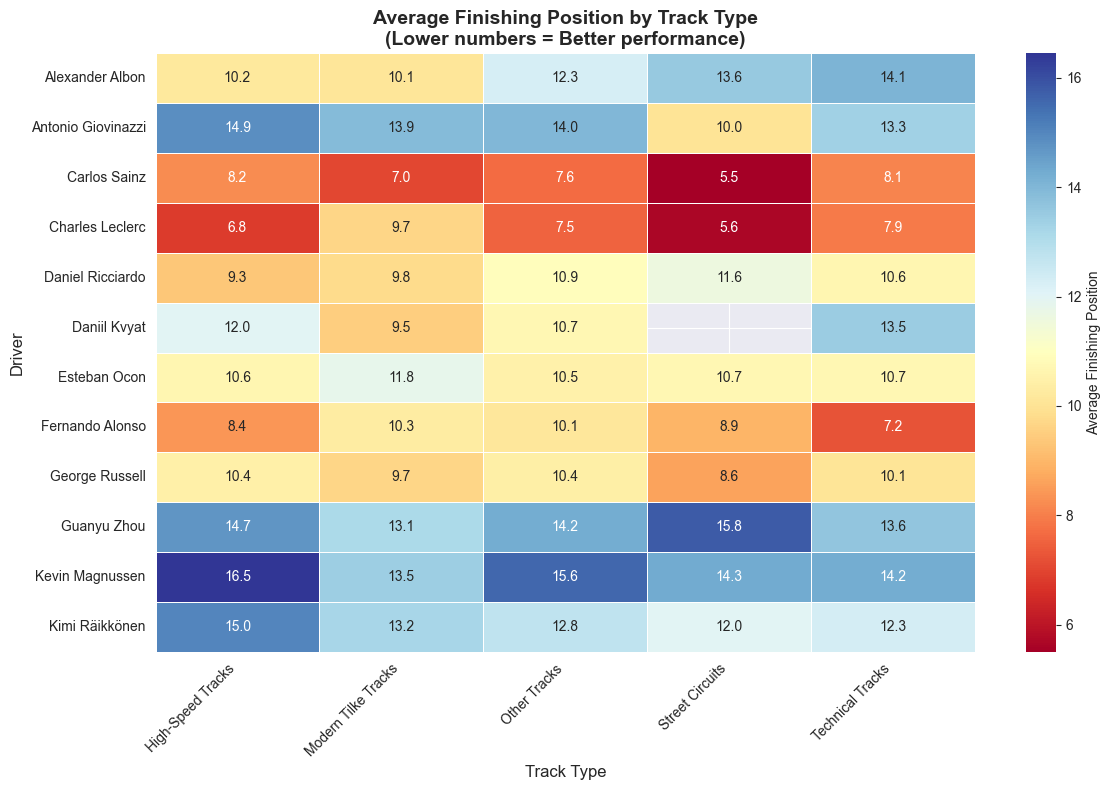


ANALYSIS 3: TRACK TYPE SPECIALIZATION ANALYSIS


<Figure size 1400x800 with 0 Axes>

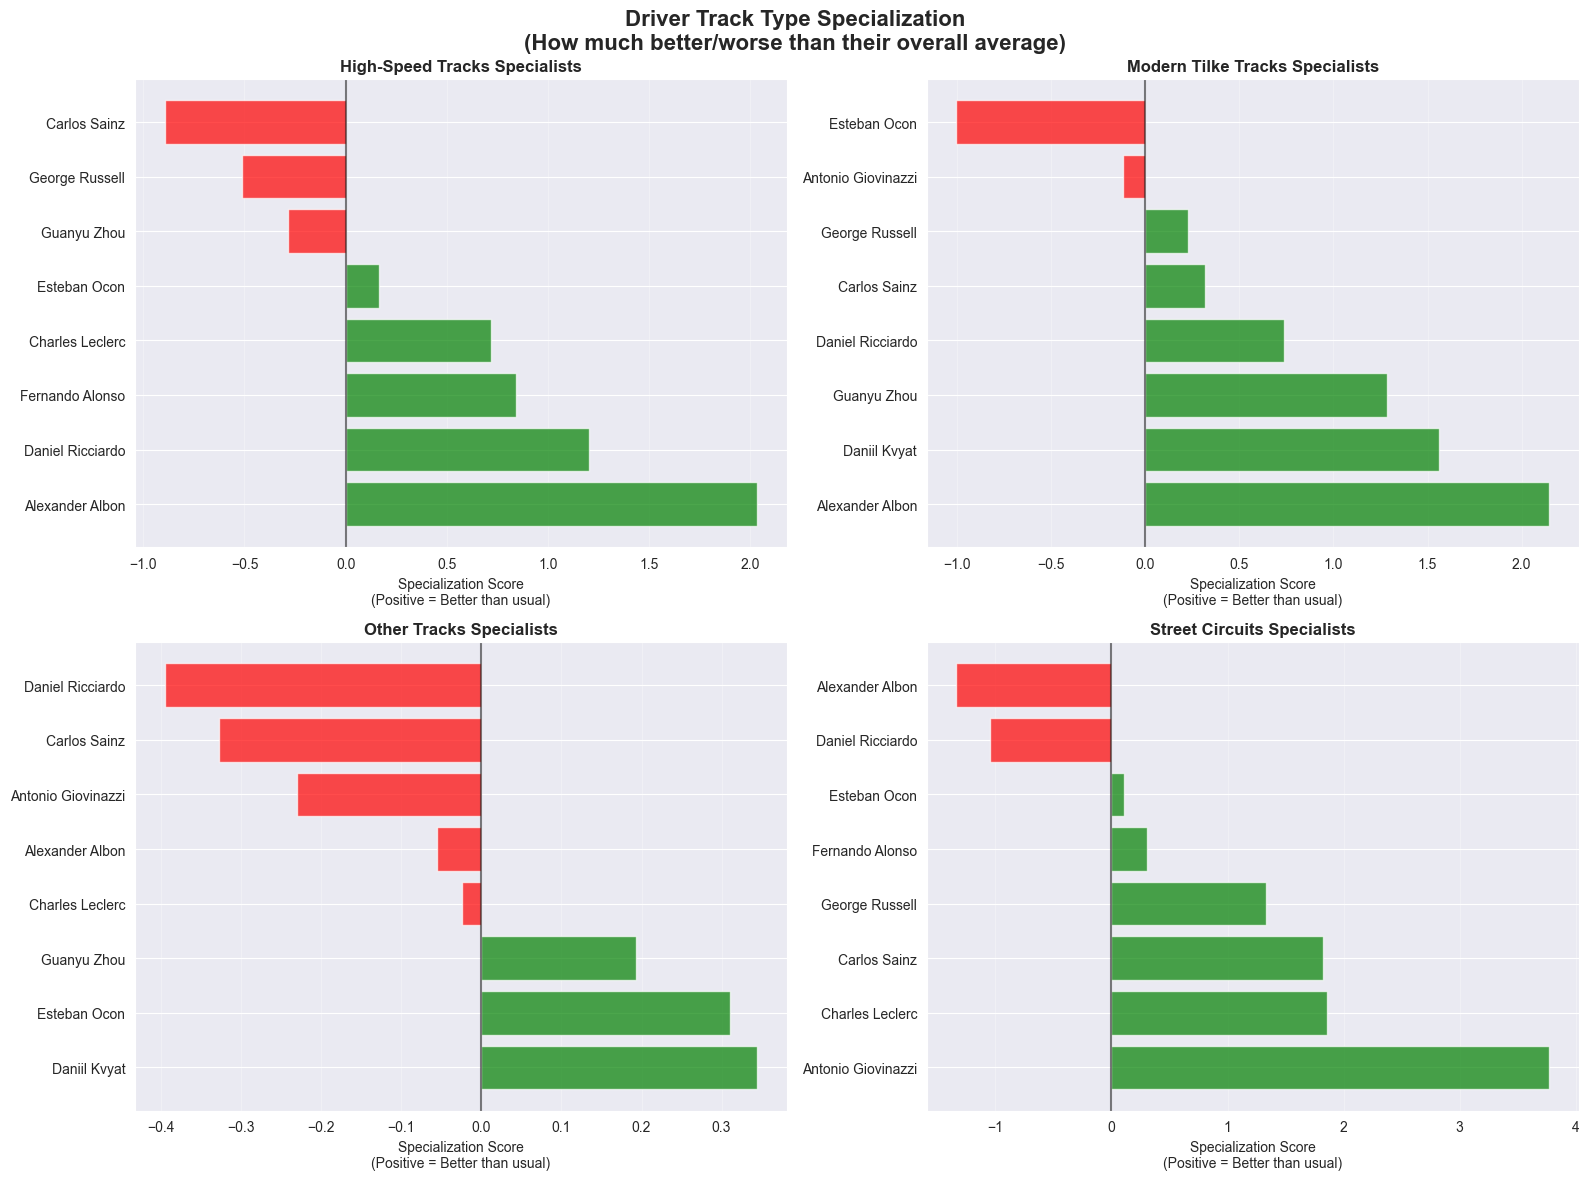


SUMMARY - TRACK TYPE INSIGHTS
Most races in dataset: Other Tracks (34 races)

Easiest track type (lowest avg winner grid): Other Tracks (1.6)
Hardest track type (highest avg winner grid): High-Speed Tracks (3.9)

MOST SPECIALIZED DRIVERS:
  High-Speed Tracks: Alexander Albon (+2.0 positions better)
  Modern Tilke Tracks: Alexander Albon (+2.1 positions better)
  Other Tracks: Daniil Kvyat (+0.3 positions better)
  Street Circuits: Antonio Giovinazzi (+3.8 positions better)
  Technical Tracks: Fernando Alonso (+2.0 positions better)

 INTERPRETATION:
• Win Rate Heatmap: Shows who wins most at each track type
• Position Heatmap: Shows consistent performance (lower = better)
• Specialization Bars: Shows who performs better/worse than their usual level
• Green bars = Better than usual, Red bars = Worse than usual

 For race prediction:
• Check what type of track the next race is
• Look up which drivers historically perform best at that track type
• Combine with recent form and qualifying 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_csv("csv/results.csv")
drivers_df = pd.read_csv("csv/drivers.csv")
races_df = pd.read_csv("csv/races.csv")
circuits_df = pd.read_csv("csv/circuits.csv")

print("DRIVER PERFORMANCE BY TRACK TYPE ANALYSIS")
print("=" * 60)

analysis_data = pd.merge(results_df, races_df[['raceId', 'circuitId', 'name', 'year']], on='raceId')
analysis_data = pd.merge(analysis_data, drivers_df[['driverId', 'forename', 'surname']], on='driverId')
analysis_data = pd.merge(analysis_data, circuits_df[['circuitId', 'name', 'location', 'country']],
                        on='circuitId', suffixes=('_race', '_circuit'))

analysis_data['full_name'] = analysis_data['forename'] + ' ' + analysis_data['surname']


analysis_data['positionOrder'] = pd.to_numeric(analysis_data['positionOrder'], errors='coerce')
analysis_data['points'] = pd.to_numeric(analysis_data['points'], errors='coerce')

clean_data = analysis_data[
    (analysis_data['positionOrder'].notna()) &
    (analysis_data['positionOrder'] > 0)
].copy()

print(f"Analyzing {len(clean_data)} race results across {clean_data['name_circuit'].nunique()} circuits")

track_categories = {
    'Street Circuits': [
        'Monaco', 'Marina Bay', 'Baku', 'Jeddah', 'Miami', 'Las Vegas',
        'Adelaide', 'Long Beach', 'Detroit', 'Phoenix'
    ],

    'High-Speed Tracks': [
        'Monza', 'Spa-Francorchamps', 'Indianapolis', 'Hockenheim',
        'Silverstone', 'AVUS', 'Reims'
    ],

    'Technical Tracks': [
        'Suzuka', 'Interlagos', 'Hungaroring', 'Nürburgring', 'Imola',
        'Circuit Gilles Villeneuve', 'Albert Park', 'Sepang'
    ],

    'Modern Tilke Tracks': [
        'Bahrain', 'Shanghai', 'Istanbul', 'Valencia', 'Abu Dhabi',
        'Korea', 'Buddh', 'Sochi', 'Circuit of the Americas', 'Paul Ricard'
    ]
}

def categorize_circuit(circuit_name):
    for category, circuits in track_categories.items():
        if any(keyword in circuit_name for keyword in circuits):
            return category
    return 'Other Tracks'

clean_data['track_type'] = clean_data['name_circuit'].apply(categorize_circuit)

print(f"\nTrack type distribution:")
track_distribution = clean_data['track_type'].value_counts()
for track_type, count in track_distribution.items():
    print(f"  {track_type}: {count} races")


recent_years = sorted(clean_data['year'].unique())[-5:]
recent_data = clean_data[clean_data['year'].isin(recent_years)].copy()

print(f"\nFocusing on recent years: {recent_years}")
print(f"Recent data: {len(recent_data)} race results")


print("\n" + "="*60)
print("ANALYSIS 1: WIN RATE BY TRACK TYPE")
print("="*60)


winners = recent_data[recent_data['positionOrder'] == 1].copy()

if len(winners) > 0:
    driver_track_wins = winners.groupby(['full_name', 'track_type']).size().unstack(fill_value=0)
    driver_track_races = recent_data.groupby(['full_name', 'track_type']).size().unstack(fill_value=0)

    win_rates = (driver_track_wins / driver_track_races.replace(0, 1) * 100).fillna(0)

    total_wins = driver_track_wins.sum(axis=1)
    top_winners = total_wins[total_wins >= 3].index

    if len(top_winners) > 0:
        win_rates_filtered = win_rates.loc[top_winners]

#heatmap
        plt.figure(figsize=(12, 8))

        sns.heatmap(win_rates_filtered, annot=True, fmt='.1f', cmap='Reds',
                   cbar_kws={'label': 'Win Rate (%)'}, linewidths=0.5)

        plt.title('Driver Win Rate by Track Type (%)\n(Drivers with 3+ wins, Recent 5 Years)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Track Type', fontsize=12)
        plt.ylabel('Driver', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("\nTOP PERFORMERS BY TRACK TYPE:")
        print("-" * 40)

        for track_type in win_rates_filtered.columns:
            if track_type in win_rates_filtered.columns:
                top_driver = win_rates_filtered[track_type].idxmax()
                top_rate = win_rates_filtered.loc[top_driver, track_type]
                total_wins_type = driver_track_wins.loc[top_driver, track_type]

                print(f"{track_type}:")
                print(f"  Best: {top_driver} ({top_rate:.1f}% win rate, {total_wins_type} wins)")

print("\n" + "="*60)
print("ANALYSIS 2: AVERAGE FINISHING POSITION BY TRACK TYPE")
print("="*60)


avg_positions = recent_data.groupby(['full_name', 'track_type'])['positionOrder'].mean().unstack()

driver_race_counts = recent_data.groupby('full_name').size()
regular_drivers = driver_race_counts[driver_race_counts >= 10].index

if len(regular_drivers) > 0:
    avg_positions_filtered = avg_positions.loc[regular_drivers].head(12)  # Top 12 drivers

    #heatmap2
    plt.figure(figsize=(12, 8))

    # lower postition darker
    sns.heatmap(avg_positions_filtered, annot=True, fmt='.1f', cmap='RdYlBu',
               cbar_kws={'label': 'Average Finishing Position'}, linewidths=0.5)

    plt.title('Average Finishing Position by Track Type\n(Lower numbers = Better performance)',
             fontsize=14, fontweight='bold')
    plt.xlabel('Track Type', fontsize=12)
    plt.ylabel('Driver', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ANALYSIS 3: TRACK TYPE SPECIALIZATION ANALYSIS")
print("="*60)

driver_overall_avg = recent_data.groupby('full_name')['positionOrder'].mean()
specialization_scores = pd.DataFrame()

for track_type in avg_positions.columns:
    if track_type in avg_positions.columns:

        specialization = driver_overall_avg - avg_positions[track_type]
        specialization_scores[track_type] = specialization

specialization_filtered = specialization_scores.loc[regular_drivers].head(10)

plt.figure(figsize=(14, 8))

#bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, track_type in enumerate(specialization_filtered.columns[:4]):
    if i < len(axes):
        top_specialists = specialization_filtered[track_type].nlargest(8)

        colors = ['green' if x > 0 else 'red' for x in top_specialists.values]

        axes[i].barh(range(len(top_specialists)), top_specialists.values, color=colors, alpha=0.7)
        axes[i].set_yticks(range(len(top_specialists)))
        axes[i].set_yticklabels(top_specialists.index)
        axes[i].set_xlabel('Specialization Score\n(Positive = Better than usual)')
        axes[i].set_title(f'{track_type} Specialists', fontweight='bold')
        axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.5)
        axes[i].grid(True, alpha=0.3, axis='x')

plt.suptitle('Driver Track Type Specialization\n(How much better/worse than their overall average)',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#recap
print("\n" + "="*60)
print("SUMMARY - TRACK TYPE INSIGHTS")
print("="*60)

if len(winners) > 0:
    # Most dominant track type
    wins_by_type = winners['track_type'].value_counts()
    print(f"Most races in dataset: {wins_by_type.index[0]} ({wins_by_type.iloc[0]} races)")

    # Track type difficulty
    if 'grid' in winners.columns:
        winners['grid'] = pd.to_numeric(winners['grid'], errors='coerce')
        winner_grid_avg = winners.groupby('track_type')['grid'].mean().sort_values()
        print(f"\nEasiest track type (lowest avg winner grid): {winner_grid_avg.index[0]} ({winner_grid_avg.iloc[0]:.1f})")
        print(f"Hardest track type (highest avg winner grid): {winner_grid_avg.index[-1]} ({winner_grid_avg.iloc[-1]:.1f})")

    if not specialization_filtered.empty:
        print(f"\nMOST SPECIALIZED DRIVERS:")
        for track_type in specialization_filtered.columns:
            best_specialist = specialization_filtered[track_type].idxmax()
            best_score = specialization_filtered.loc[best_specialist, track_type]
            if not pd.isna(best_score):
                print(f"  {track_type}: {best_specialist} (+{best_score:.1f} positions better)")

print(f"\n INTERPRETATION:")
print("• Win Rate Heatmap: Shows who wins most at each track type")
print("• Position Heatmap: Shows consistent performance (lower = better)")
print("• Specialization Bars: Shows who performs better/worse than their usual level")
print("• Green bars = Better than usual, Red bars = Worse than usual")

print(f"\n For race prediction:")
print("• Check what type of track the next race is")
print("• Look up which drivers historically perform best at that track type")
print("• Combine with recent form and qualifying performance")
print("• Specialists often outperform their usual ranking at their preferred track types")

C:\Users\rosas\AppData\Local\Temp\ipykernel_15772\3542989486.py:132: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rosas\PycharmProjects\PythonProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


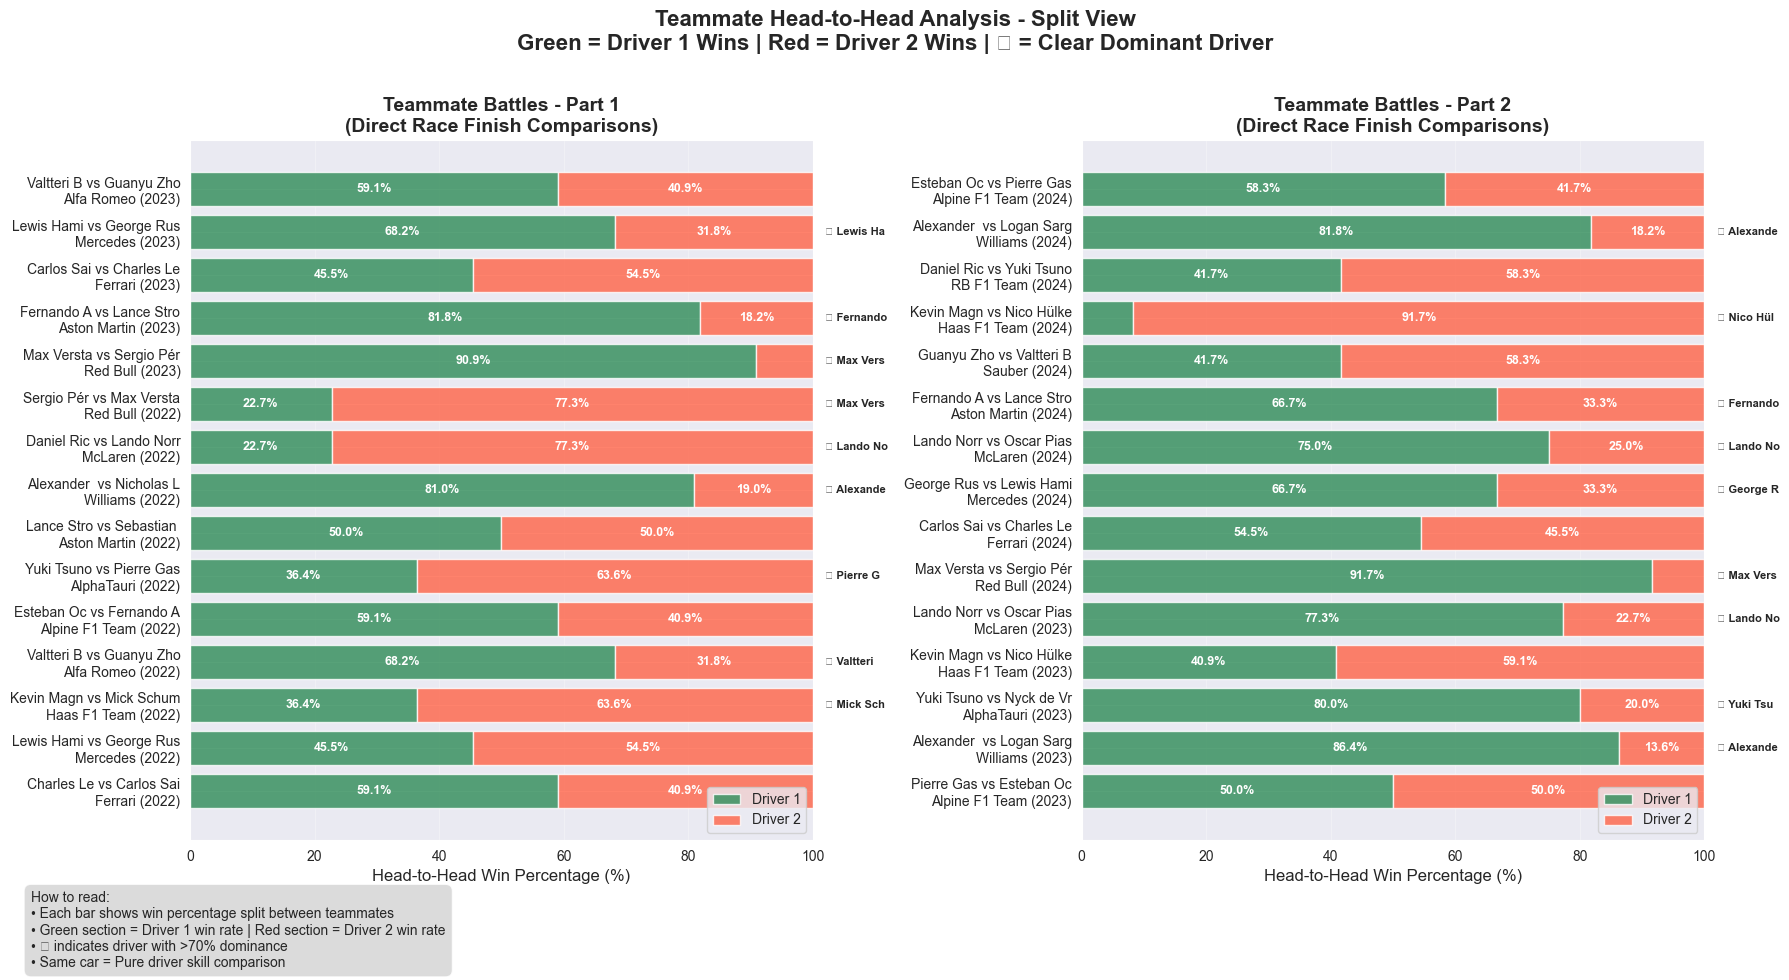


🏆 MOST DOMINANT TEAMMATE PERFORMANCES:
----------------------------------------------------------------------
Winner               Loser                Score      Dominance    Team/Year      
----------------------------------------------------------------------
Max Verstappen       Sergio Pérez         11-1       83.3%        Red Bull 2024  
Nico Hülkenberg      Kevin Magnussen      11-1       83.3%        Haas F1 Te 2024
Max Verstappen       Sergio Pérez         20-2       81.8%        Red Bull 2023  
Alexander Albon      Logan Sargeant       19-3       72.7%        Williams 2023  
Fernando Alonso      Lance Stroll         18-4       63.6%        Aston Mart 2023
Alexander Albon      Logan Sargeant       9-2        63.6%        Williams 2024  
Alexander Albon      Nicholas Latifi      17-4       61.9%        Williams 2022  
Yuki Tsunoda         Nyck de Vries        8-2        60.0%        AlphaTauri 2023

📊 BATTLE STATISTICS:
• Total teammate battles analyzed: 30
• Battles with >70% 

In [14]:
if len(h2h_df) > 0:
    total_battles = len(h2h_df)
    mid_point = total_battles // 2

    viz_data = []
    labels = []

    for _, battle in h2h_df.iterrows():
        battle_label = f"{battle['driver1'][:10]} vs {battle['driver2'][:10]}\n{battle['team'][:15]} ({battle['year']})"
        labels.append(battle_label)

        d1_win_pct = (battle['d1_wins'] / battle['total_battles']) * 100
        d2_win_pct = (battle['d2_wins'] / battle['total_battles']) * 100

        viz_data.append([d1_win_pct, d2_win_pct, battle['driver1'], battle['driver2']])

    viz_array = np.array(viz_data, dtype=object)

    # split
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

    first_half = slice(0, mid_point)
    second_half = slice(mid_point, total_battles)

    viz_data_1 = viz_array[first_half]
    labels_1 = labels[first_half]

    d1_pcts_1 = [float(x[0]) for x in viz_data_1]
    d2_pcts_1 = [float(x[1]) for x in viz_data_1]

    # color
    bars1_1 = ax1.barh(range(len(labels_1)), d1_pcts_1,
                      label='Driver 1', color='#2E8B57', alpha=0.8)  # Sea Green
    bars1_2 = ax1.barh(range(len(labels_1)), d2_pcts_1, left=d1_pcts_1,
                      label='Driver 2', color='#FF6347', alpha=0.8)  # Tomato Red

    ax1.set_yticks(range(len(labels_1)))
    ax1.set_yticklabels(labels_1, fontsize=10)
    ax1.set_xlabel('Head-to-Head Win Percentage (%)', fontsize=12)
    ax1.set_title('Teammate Battles - Part 1\n(Direct Race Finish Comparisons)',
                 fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, 100)

    for i, (d1_pct, d2_pct) in enumerate(zip(d1_pcts_1, d2_pcts_1)):
        if d1_pct > 10:
            ax1.text(d1_pct/2, i, f'{d1_pct:.1f}%',
                    ha='center', va='center', fontweight='bold', color='white', fontsize=9)
        if d2_pct > 10:
            ax1.text(d1_pct + d2_pct/2, i, f'{d2_pct:.1f}%',
                    ha='center', va='center', fontweight='bold', color='white', fontsize=9)

        winner_name = viz_data_1[i][2] if d1_pct > d2_pct else viz_data_1[i][3]
        margin = abs(d1_pct - d2_pct)
        if margin > 20:  # Significant dominance
            ax1.text(102, i, f' {winner_name[:8]}',
                    ha='left', va='center', fontsize=8, fontweight='bold')

    if mid_point < total_battles:
        viz_data_2 = viz_array[second_half]
        labels_2 = labels[second_half]

        d1_pcts_2 = [float(x[0]) for x in viz_data_2]
        d2_pcts_2 = [float(x[1]) for x in viz_data_2]

        bars2_1 = ax2.barh(range(len(labels_2)), d1_pcts_2,
                          label='Driver 1', color='#2E8B57', alpha=0.8)
        bars2_2 = ax2.barh(range(len(labels_2)), d2_pcts_2, left=d1_pcts_2,
                          label='Driver 2', color='#FF6347', alpha=0.8)

        ax2.set_yticks(range(len(labels_2)))
        ax2.set_yticklabels(labels_2, fontsize=10)
        ax2.set_xlabel('Head-to-Head Win Percentage (%)', fontsize=12)
        ax2.set_title('Teammate Battles - Part 2\n(Direct Race Finish Comparisons)',
                     fontsize=14, fontweight='bold')
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3, axis='x')
        ax2.set_xlim(0, 100)

        # Add percentage
        for i, (d1_pct, d2_pct) in enumerate(zip(d1_pcts_2, d2_pcts_2)):
            # Driver 1 percentage (green section)
            if d1_pct > 10:  # Only show if bar is wide enough
                ax2.text(d1_pct/2, i, f'{d1_pct:.1f}%',
                        ha='center', va='center', fontweight='bold', color='white', fontsize=9)

            if d2_pct > 10:
                ax2.text(d1_pct + d2_pct/2, i, f'{d2_pct:.1f}%',
                        ha='center', va='center', fontweight='bold', color='white', fontsize=9)


            winner_name = viz_data_2[i][2] if d1_pct > d2_pct else viz_data_2[i][3]
            margin = abs(d1_pct - d2_pct)
            if margin > 20:
                ax2.text(102, i, f' {winner_name[:8]}',
                        ha='left', va='center', fontsize=8, fontweight='bold')
    else:
        ax2.set_visible(False)

    fig.suptitle('Teammate Head-to-Head Analysis - Split View\n' +
                'Green = Driver 1 Wins | Red = Driver 2 Wins |  = Clear Dominant Driver',
                fontsize=16, fontweight='bold', y=0.98)

    interpretation_text = (
        "How to read:\n"
        "• Each bar shows win percentage split between teammates\n"
        "• Green section = Driver 1 win rate | Red section = Driver 2 win rate\n"
        "•  indicates driver with >70% dominance\n"
        "• Same car = Pure driver skill comparison"
    )

    fig.text(0.02, 0.02, interpretation_text, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8),
             verticalalignment='bottom')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)
    plt.show()

    # recap
    print("\n" + "🏆 MOST DOMINANT TEAMMATE PERFORMANCES:")
    print("-" * 70)
    print(f"{'Winner':<20} {'Loser':<20} {'Score':<10} {'Dominance':<12} {'Team/Year':<15}")
    print("-" * 70)

    dominance_battles = []
    for _, battle in h2h_df.iterrows():
        win_margin = abs(battle['d1_wins'] - battle['d2_wins'])
        total = battle['total_battles']
        dominance_pct = (win_margin / total) * 100

        winner = battle['driver1'] if battle['d1_wins'] > battle['d2_wins'] else battle['driver2']
        loser = battle['driver2'] if battle['d1_wins'] > battle['d2_wins'] else battle['driver1']
        wins = max(battle['d1_wins'], battle['d2_wins'])
        losses = min(battle['d1_wins'], battle['d2_wins'])

        dominance_battles.append({
            'winner': winner,
            'loser': loser,
            'score': f"{wins}-{losses}",
            'dominance': dominance_pct,
            'team_year': f"{battle['team'][:10]} {battle['year']}"
        })

    dominance_battles.sort(key=lambda x: x['dominance'], reverse=True)

    for battle in dominance_battles[:8]:
        winner_short = battle['winner'][:19]
        loser_short = battle['loser'][:19]
        score = battle['score']
        dominance = f"{battle['dominance']:.1f}%"
        team_year = battle['team_year']

        print(f"{winner_short:<20} {loser_short:<20} {score:<10} {dominance:<12} {team_year:<15}")

    print(f"\n BATTLE STATISTICS:")
    print(f"• Total teammate battles analyzed: {len(h2h_df)}")
    print(f"• Battles with >70% dominance: {len([b for b in dominance_battles if b['dominance'] > 70])}")
    print(f"• Close battles (<60% dominance): {len([b for b in dominance_battles if b['dominance'] < 60])}")

    most_competitive = min(dominance_battles, key=lambda x: x['dominance'])
    print(f"• Most competitive battle: {most_competitive['winner']} vs {most_competitive['loser']} ({most_competitive['dominance']:.1f}% margin)")

Data loaded successfully!
Results records: 26519
Qualifying records: 10254
Merged records: 10254
Clean data records: 10254


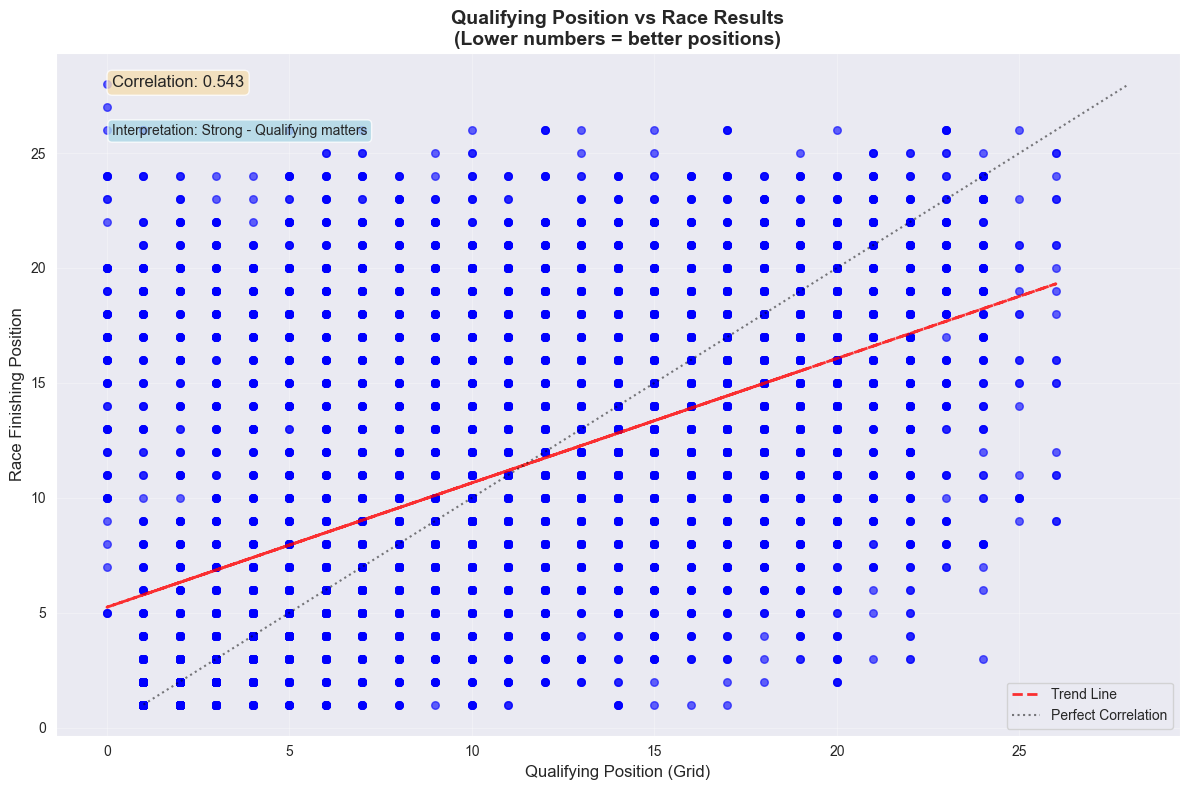


ANALYSIS SUMMARY
Correlation coefficient: 0.543
Data points analyzed: 10,254

Position Changes:
Improved from grid: 5,070 (49.4%)
Dropped from grid: 3,915 (38.2%)
Same as grid: 1,269 (12.4%)
Average positions gained: 4.2
Average positions lost: 5.8


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results_df = pd.read_csv("csv/results.csv")
qualifying_df = pd.read_csv("csv/qualifying.csv")

print("Data loaded successfully!")
print(f"Results records: {len(results_df)}")
print(f"Qualifying records: {len(qualifying_df)}")

merged_df = pd.merge(qualifying_df, results_df, on=['raceId', 'driverId'], how='inner')

print(f"Merged records: {len(merged_df)}")

merged_df = merged_df[(merged_df['grid'] != '\\N') & (merged_df['positionOrder'] != '\\N')]
merged_df['grid'] = pd.to_numeric(merged_df['grid'])
merged_df['positionOrder'] = pd.to_numeric(merged_df['positionOrder'])

merged_df = merged_df[(merged_df['positionOrder'] > 0) & (merged_df['positionOrder'].notna())]

print(f"Clean data records: {len(merged_df)}")



#scatter graph
plt.figure(figsize=(12, 8))

#quali vs race
plt.scatter(merged_df['grid'], merged_df['positionOrder'], alpha=0.6, s=30, color='blue')

#trend line
z = np.polyfit(merged_df['grid'], merged_df['positionOrder'], 1)
p = np.poly1d(z)
plt.plot(merged_df['grid'], p(merged_df['grid']), "r--", alpha=0.8, linewidth=2, label='Trend Line')

# Calculate correlation
correlation = np.corrcoef(merged_df['grid'], merged_df['positionOrder'])[0,1]

plt.xlabel('Qualifying Position (Grid)', fontsize=12)
plt.ylabel('Race Finishing Position', fontsize=12)
plt.title('Qualifying Position vs Race Results\n(Lower numbers = better positions)', fontsize=14, fontweight='bold')

# Add diagonal line
max_pos = max(merged_df['grid'].max(), merged_df['positionOrder'].max())
plt.plot([1, max_pos], [1, max_pos], 'k:', alpha=0.5, label='Perfect Correlation')


plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
         fontsize=12)


if correlation > 0.7:
    interpretation = "Very Strong - Grid crucial!"
elif correlation > 0.5:
    interpretation = "Strong - Qualifying matters"
elif correlation > 0.3:
    interpretation = "Moderate - Some overtaking"
else:
    interpretation = "Weak - Very unpredictable"

plt.text(0.05, 0.88, f'Interpretation: {interpretation}',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8),
         fontsize=10)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("ANALYSIS SUMMARY")
print(f"{'='*50}")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Data points analyzed: {len(merged_df):,}")


better_than_grid = len(merged_df[merged_df['positionOrder'] < merged_df['grid']])
worse_than_grid = len(merged_df[merged_df['positionOrder'] > merged_df['grid']])
same_as_grid = len(merged_df[merged_df['positionOrder'] == merged_df['grid']])

print(f"\nPosition Changes:")
print(f"Improved from grid: {better_than_grid:,} ({better_than_grid/len(merged_df)*100:.1f}%)")
print(f"Dropped from grid: {worse_than_grid:,} ({worse_than_grid/len(merged_df)*100:.1f}%)")
print(f"Same as grid: {same_as_grid:,} ({same_as_grid/len(merged_df)*100:.1f}%)")


avg_improvement = merged_df[merged_df['positionOrder'] < merged_df['grid']]['grid'] - merged_df[merged_df['positionOrder'] < merged_df['grid']]['positionOrder']
avg_decline = merged_df[merged_df['positionOrder'] > merged_df['grid']]['positionOrder'] - merged_df[merged_df['positionOrder'] > merged_df['grid']]['grid']

if len(avg_improvement) > 0:
    print(f"Average positions gained: {avg_improvement.mean():.1f}")
if len(avg_decline) > 0:
    print(f"Average positions lost: {avg_decline.mean():.1f}")

print(f"{'='*50}")

Using 2024 season data
Total winners found: 6
Total races analyzed: 12


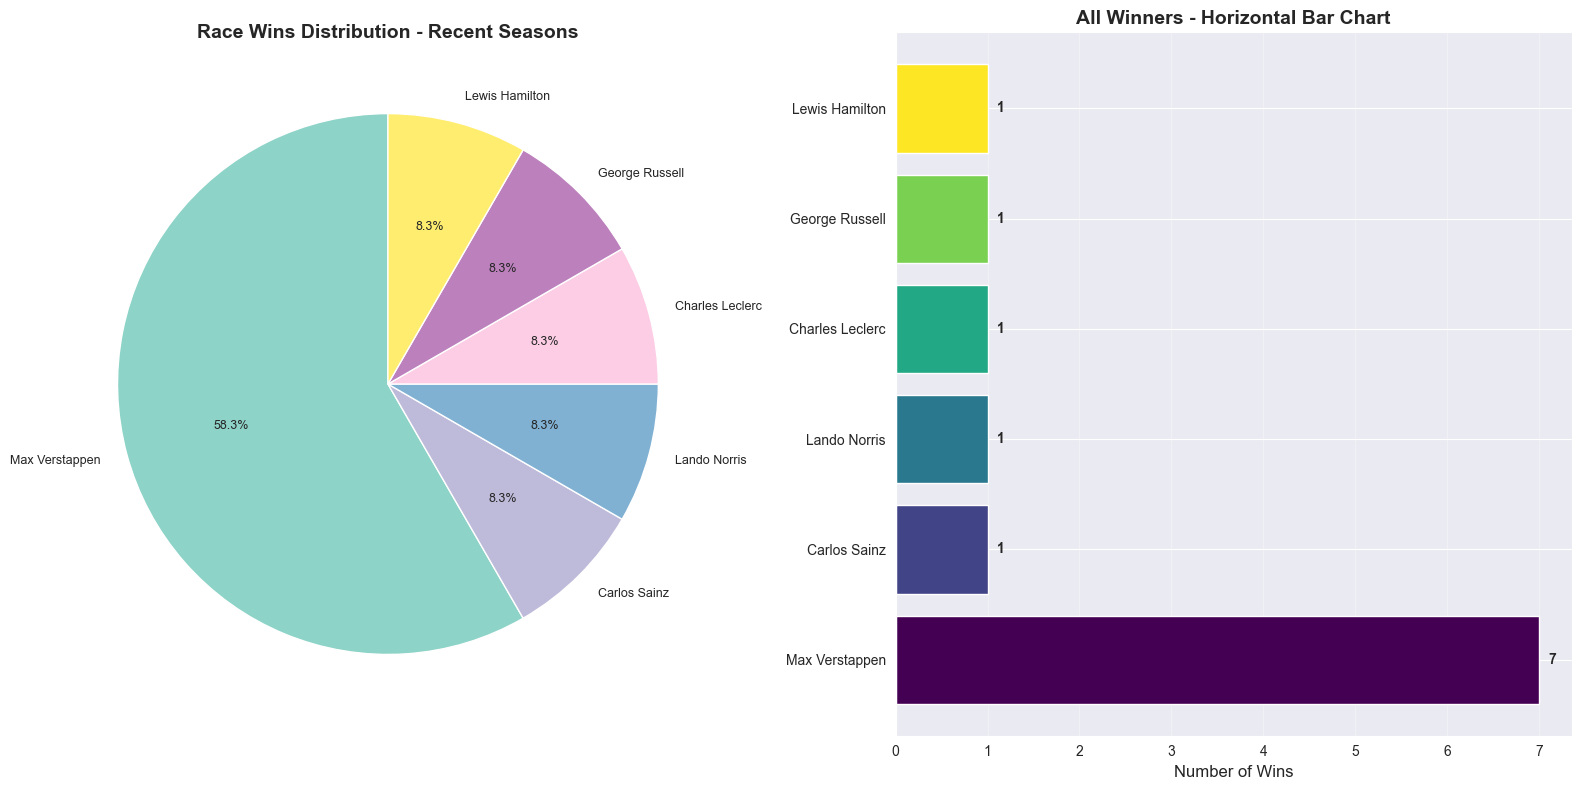


DRIVER WIN ANALYSIS
Top 10 Winners:
 1. Max Verstappen            |  7 wins (58.3%)
 2. Carlos Sainz              |  1 wins ( 8.3%)
 3. Lando Norris              |  1 wins ( 8.3%)
 4. Charles Leclerc           |  1 wins ( 8.3%)
 5. George Russell            |  1 wins ( 8.3%)
 6. Lewis Hamilton            |  1 wins ( 8.3%)

Total unique winners: 6
Most successful driver: Max Verstappen with 7 wins


In [9]:
latest_season = races_df['year'].max()
print(f"Using {latest_season} season data")

current_season_races = races_df[races_df['year'] == latest_season]['raceId'].tolist()

winners = results_df[
    (results_df['raceId'].isin(current_season_races)) &
    (results_df['positionOrder'] == 1)
]

winners = pd.merge(winners, drivers_df[['driverId', 'forename', 'surname']], on='driverId')
winners['full_name'] = winners['forename'] + ' ' + winners['surname']

win_counts = winners['full_name'].value_counts()

if len(win_counts) == 0:
    recent_seasons = races_df['year'].nlargest(3).tolist()
    print(f"No current season data found, using years: {recent_seasons}")

    recent_races = races_df[races_df['year'].isin(recent_seasons)]['raceId'].tolist()
    winners = results_df[
        (results_df['raceId'].isin(recent_races)) &
        (results_df['positionOrder'] == 1)
    ]
    winners = pd.merge(winners, drivers_df[['driverId', 'forename', 'surname']], on='driverId')
    winners['full_name'] = winners['forename'] + ' ' + winners['surname']
    win_counts = winners['full_name'].value_counts()

print(f"Total winners found: {len(win_counts)}")
print(f"Total races analyzed: {len(winners)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

top_winners = win_counts.head(8)
others_count = win_counts.iloc[8:].sum() if len(win_counts) > 8 else 0

if others_count > 0:
    pie_data = list(top_winners.values) + [others_count]
    pie_labels = list(top_winners.index) + ['Others']
else:
    pie_data = list(top_winners.values)
    pie_labels = list(top_winners.index)


colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

wedges, texts, autotexts = ax1.pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
                                  colors=colors, startangle=90, textprops={'fontsize': 9})

ax1.set_title(f'Race Wins Distribution - Recent Seasons', fontsize=14, fontweight='bold')

# BAR CHART
ax2.barh(range(len(win_counts)), win_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(win_counts))))
ax2.set_yticks(range(len(win_counts)))
ax2.set_yticklabels(win_counts.index)
ax2.set_xlabel('Number of Wins', fontsize=12)
ax2.set_title('All Winners - Horizontal Bar Chart', fontsize=14, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

# Add labels
for i, (driver, wins) in enumerate(win_counts.items()):
    ax2.text(wins + 0.1, i, f'{wins}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


print(f"\n{'='*60}")
print("DRIVER WIN ANALYSIS")
print(f"{'='*60}")
print(f"Top 10 Winners:")
for i, (driver, wins) in enumerate(win_counts.head(10).items()):
    total_races = len(winners)
    win_percentage = (wins / total_races) * 100
    print(f"{i+1:2d}. {driver:25s} | {wins:2d} wins ({win_percentage:4.1f}%)")

print(f"\nTotal unique winners: {len(win_counts)}")
print(f"Most successful driver: {win_counts.index[0]} with {win_counts.iloc[0]} wins")

Analyzing Constructor Performance...
Using seasons: [2024, 2024]
Top constructors found: 6


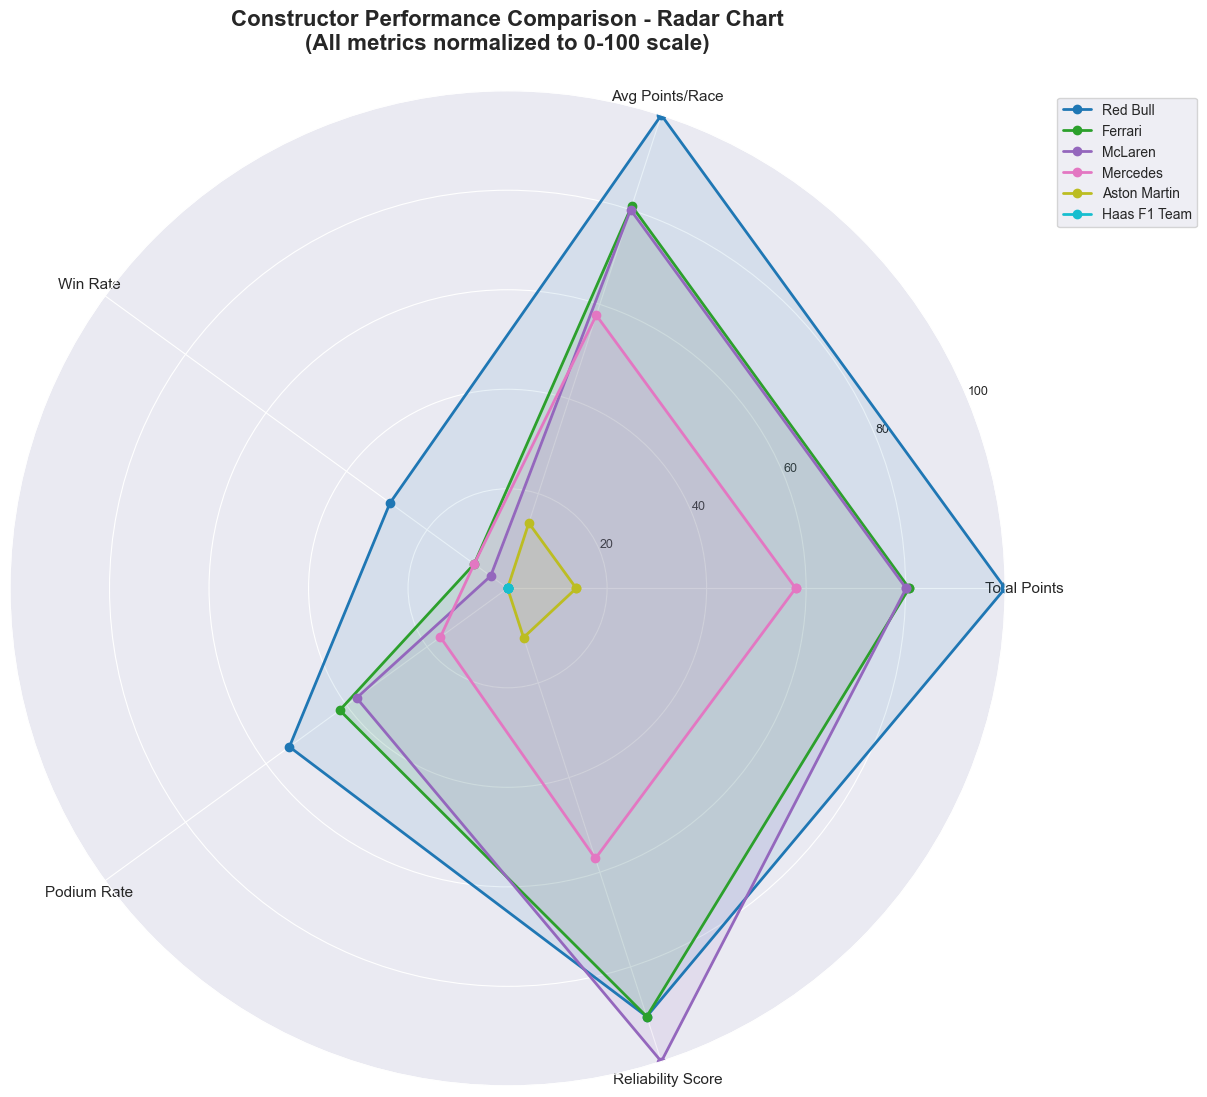

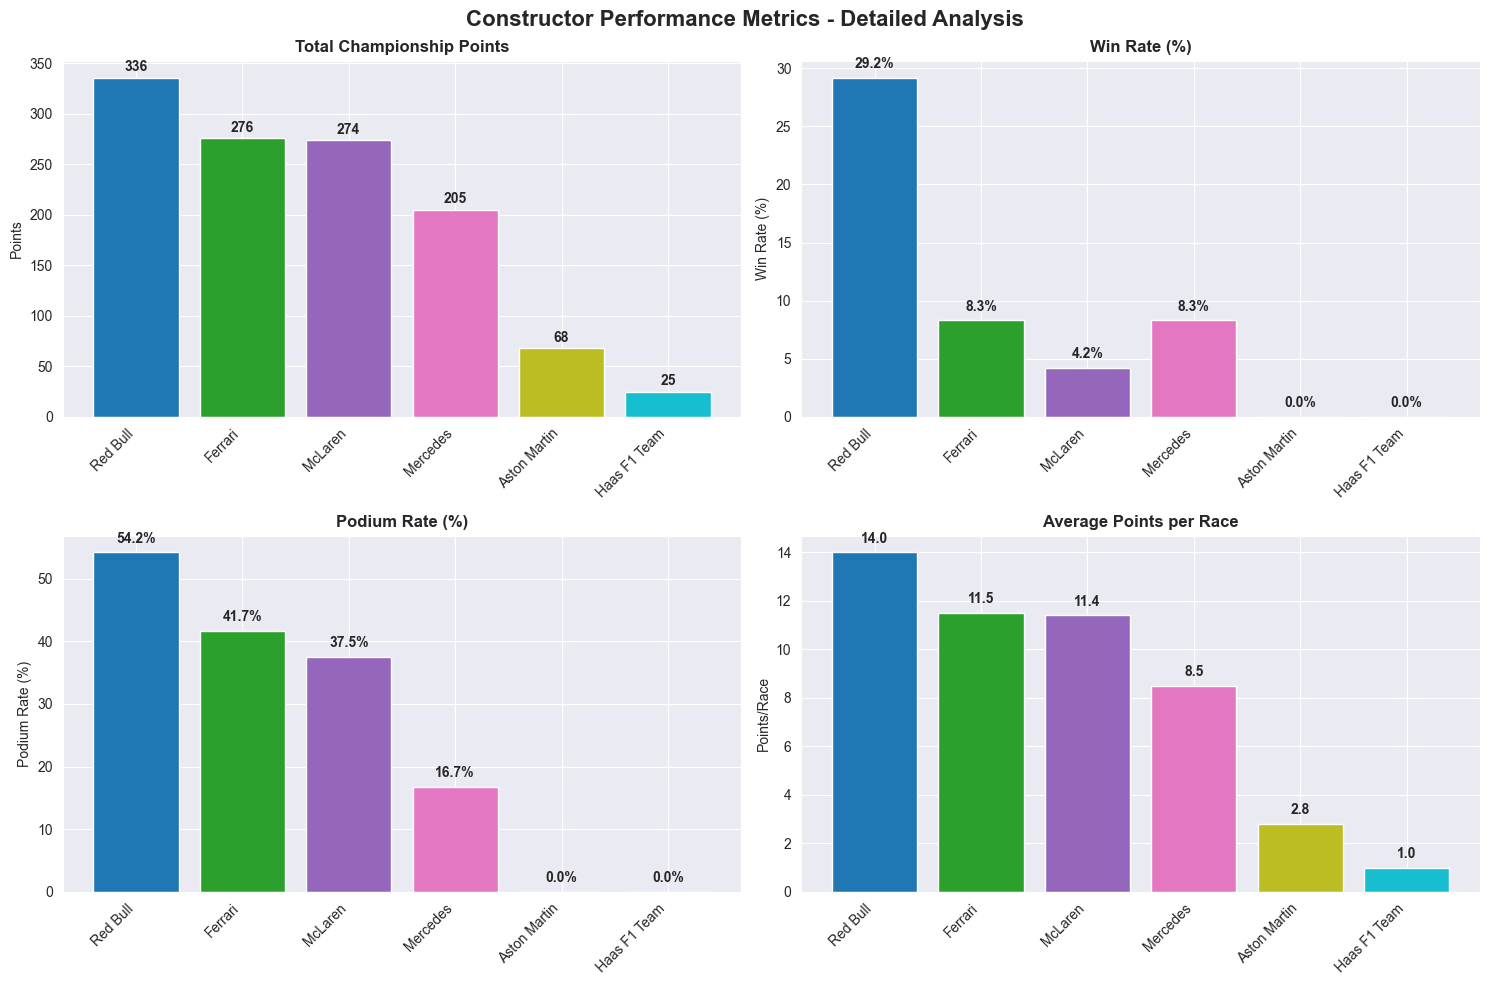


CONSTRUCTOR PERFORMANCE ANALYSIS
1. Red Bull
   Total Points: 336 | Wins: 7 | Win Rate: 29.2% | Podium Rate: 54.2%
   Avg Position: 5.6 | Points/Race: 14.0

2. Ferrari
   Total Points: 276 | Wins: 2 | Win Rate: 8.3% | Podium Rate: 41.7%
   Avg Position: 5.6 | Points/Race: 11.5

3. McLaren
   Total Points: 274 | Wins: 1 | Win Rate: 4.2% | Podium Rate: 37.5%
   Avg Position: 5.3 | Points/Race: 11.4

4. Mercedes
   Total Points: 205 | Wins: 2 | Win Rate: 8.3% | Podium Rate: 16.7%
   Avg Position: 7.1 | Points/Race: 8.5

5. Aston Martin
   Total Points: 68 | Wins: 0 | Win Rate: 0.0% | Podium Rate: 0.0%
   Avg Position: 10.9 | Points/Race: 2.8

6. Haas F1 Team
   Total Points: 25 | Wins: 0 | Win Rate: 0.0% | Podium Rate: 0.0%
   Avg Position: 12.2 | Points/Race: 1.0



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results_df = pd.read_csv("csv/results.csv")
constructors_df = pd.read_csv("csv/constructors.csv")
races_df = pd.read_csv("csv/races.csv")

print("Analyzing Constructor Performance...")

recent_seasons = races_df['year'].nlargest(2).tolist()
print(f"Using seasons: {recent_seasons}")

recent_races = races_df[races_df['year'].isin(recent_seasons)]['raceId'].tolist()

recent_results = results_df[results_df['raceId'].isin(recent_races)].copy()

# Merge
recent_results = pd.merge(recent_results, constructors_df[['constructorId', 'name']], on='constructorId')

recent_results['positionOrder'] = pd.to_numeric(recent_results['positionOrder'], errors='coerce')
recent_results['points'] = pd.to_numeric(recent_results['points'], errors='coerce')

constructor_stats = recent_results.groupby('name').agg({
    'points': ['sum', 'mean'],
    'positionOrder': ['mean', 'count', lambda x: (x == 1).sum(), lambda x: (x <= 3).sum()],
    'constructorId': 'count'
}).round(2)

constructor_stats.columns = ['Total_Points', 'Avg_Points', 'Avg_Position', 'Total_Races', 'Wins', 'Podiums', 'Entries']

constructor_stats['Win_Rate'] = (constructor_stats['Wins'] / constructor_stats['Total_Races'] * 100).round(1)
constructor_stats['Podium_Rate'] = (constructor_stats['Podiums'] / constructor_stats['Total_Races'] * 100).round(1)
constructor_stats['Points_Per_Race'] = (constructor_stats['Total_Points'] / constructor_stats['Total_Races']).round(1)

# Get top 6
top_constructors = constructor_stats.nlargest(6, 'Total_Points')

print(f"Top constructors found: {len(top_constructors)}")


categories = ['Total Points', 'Avg Points/Race', 'Win Rate', 'Podium Rate', 'Reliability Score']

def normalize_to_100(series):
    return ((series - series.min()) / (series.max() - series.min()) * 100).round(1)

radar_data = pd.DataFrame()
radar_data['Total Points'] = normalize_to_100(top_constructors['Total_Points'])
radar_data['Avg Points/Race'] = normalize_to_100(top_constructors['Points_Per_Race'])
radar_data['Win Rate'] = top_constructors['Win_Rate']
radar_data['Podium Rate'] = top_constructors['Podium_Rate']

# Reliability score
reliability_scores = 100 / (top_constructors['Avg_Position'] + 1) * 10
radar_data['Reliability Score'] = normalize_to_100(reliability_scores)

radar_data.index = top_constructors.index


fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))


N = len(categories)


angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle


colors = plt.cm.tab10(np.linspace(0, 1, len(top_constructors)))


for i, (constructor, data) in enumerate(radar_data.iterrows()):
    values = data.tolist()
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=constructor, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])


ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=9)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=10)
plt.title('Constructor Performance Comparison - Radar Chart\n(All metrics normalized to 0-100 scale)',
          size=16, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

bars1 = ax1.bar(range(len(top_constructors)), top_constructors['Total_Points'],
                color=colors[:len(top_constructors)])
ax1.set_xticks(range(len(top_constructors)))
ax1.set_xticklabels(top_constructors.index, rotation=45, ha='right')
ax1.set_title('Total Championship Points', fontweight='bold')
ax1.set_ylabel('Points')
for i, v in enumerate(top_constructors['Total_Points']):
    ax1.text(i, v + max(top_constructors['Total_Points']) * 0.01, f'{v:.0f}',
             ha='center', va='bottom', fontweight='bold')


bars2 = ax2.bar(range(len(top_constructors)), top_constructors['Win_Rate'],
                color=colors[:len(top_constructors)])
ax2.set_xticks(range(len(top_constructors)))
ax2.set_xticklabels(top_constructors.index, rotation=45, ha='right')
ax2.set_title('Win Rate (%)', fontweight='bold')
ax2.set_ylabel('Win Rate (%)')
for i, v in enumerate(top_constructors['Win_Rate']):
    ax2.text(i, v + max(top_constructors['Win_Rate']) * 0.02, f'{v:.1f}%',
             ha='center', va='bottom', fontweight='bold')

#Podium Rate
bars3 = ax3.bar(range(len(top_constructors)), top_constructors['Podium_Rate'],
                color=colors[:len(top_constructors)])
ax3.set_xticks(range(len(top_constructors)))
ax3.set_xticklabels(top_constructors.index, rotation=45, ha='right')
ax3.set_title('Podium Rate (%)', fontweight='bold')
ax3.set_ylabel('Podium Rate (%)')
for i, v in enumerate(top_constructors['Podium_Rate']):
    ax3.text(i, v + max(top_constructors['Podium_Rate']) * 0.02, f'{v:.1f}%',
             ha='center', va='bottom', fontweight='bold')

#Points per Race
bars4 = ax4.bar(range(len(top_constructors)), top_constructors['Points_Per_Race'],
                color=colors[:len(top_constructors)])
ax4.set_xticks(range(len(top_constructors)))
ax4.set_xticklabels(top_constructors.index, rotation=45, ha='right')
ax4.set_title('Average Points per Race', fontweight='bold')
ax4.set_ylabel('Points/Race')
for i, v in enumerate(top_constructors['Points_Per_Race']):
    ax4.text(i, v + max(top_constructors['Points_Per_Race']) * 0.02, f'{v:.1f}',
             ha='center', va='bottom', fontweight='bold')

plt.suptitle('Constructor Performance Metrics - Detailed Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("CONSTRUCTOR PERFORMANCE ANALYSIS")
print(f"{'='*70}")
for i, (constructor, stats) in enumerate(top_constructors.iterrows()):
    print(f"{i+1}. {constructor}")
    print(f"   Total Points: {stats['Total_Points']:.0f} | Wins: {stats['Wins']:.0f} | "
          f"Win Rate: {stats['Win_Rate']:.1f}% | Podium Rate: {stats['Podium_Rate']:.1f}%")
    print(f"   Avg Position: {stats['Avg_Position']:.1f} | Points/Race: {stats['Points_Per_Race']:.1f}")
    print()

️ WEATHER PERFORMANCE ANALYSIS - RAIN MASTERS vs DRY SPECIALISTS
Analyzing 26519 race results

Weather conditions distribution:
  Dry: 21987 races (82.9%)
  Mixed: 3888 races (14.7%)
  Wet: 644 races (2.4%)

Focusing on recent years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Recent data: 1899 race results

ANALYSIS 1: DRIVER PERFORMANCE BY WEATHER CONDITIONS


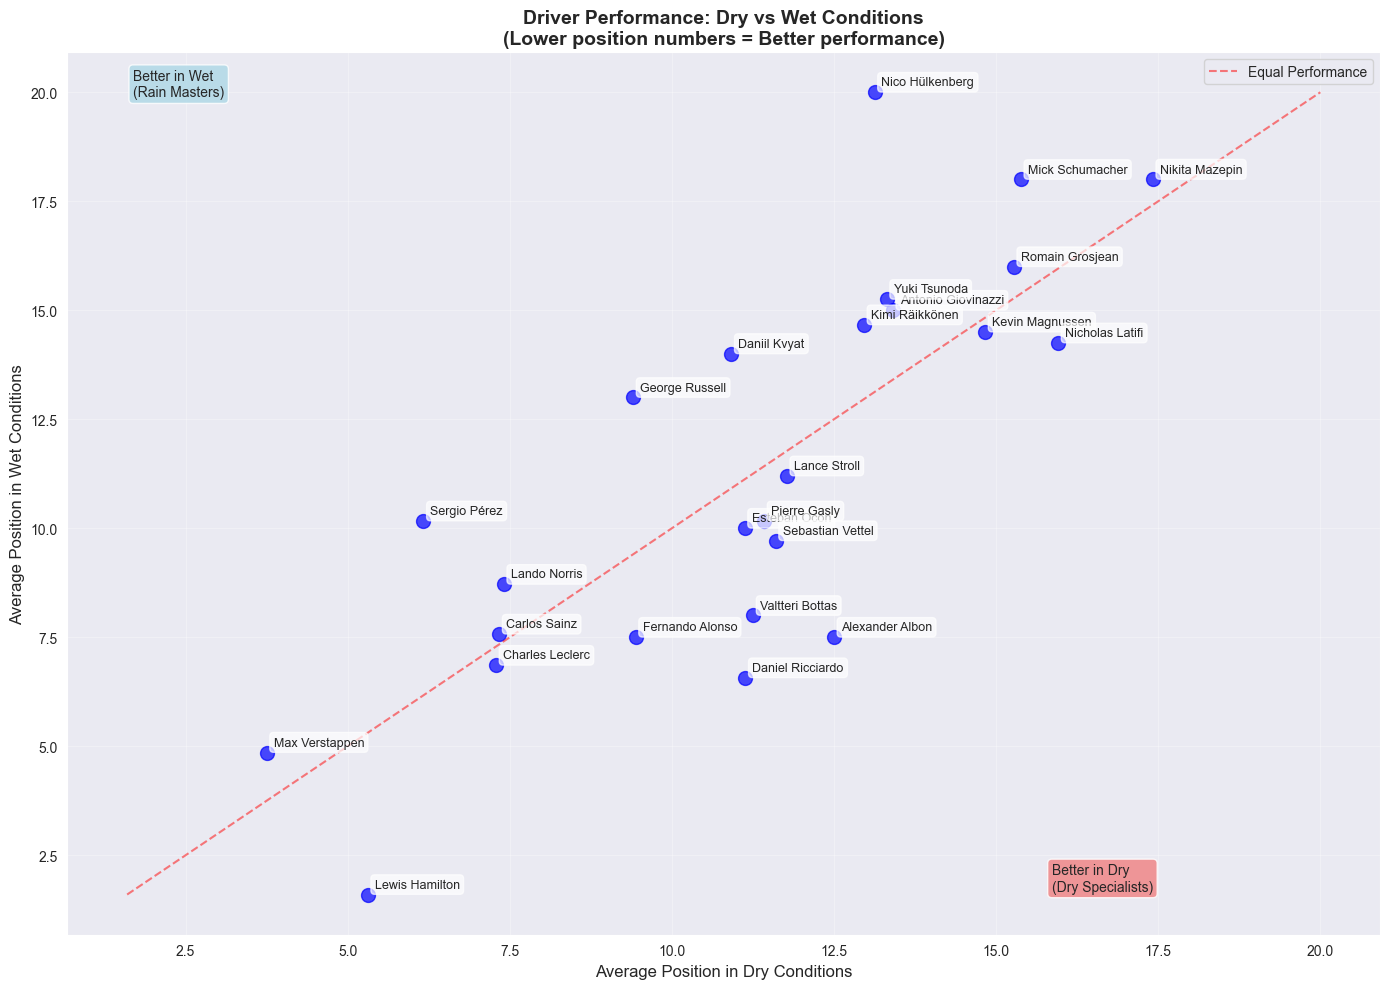

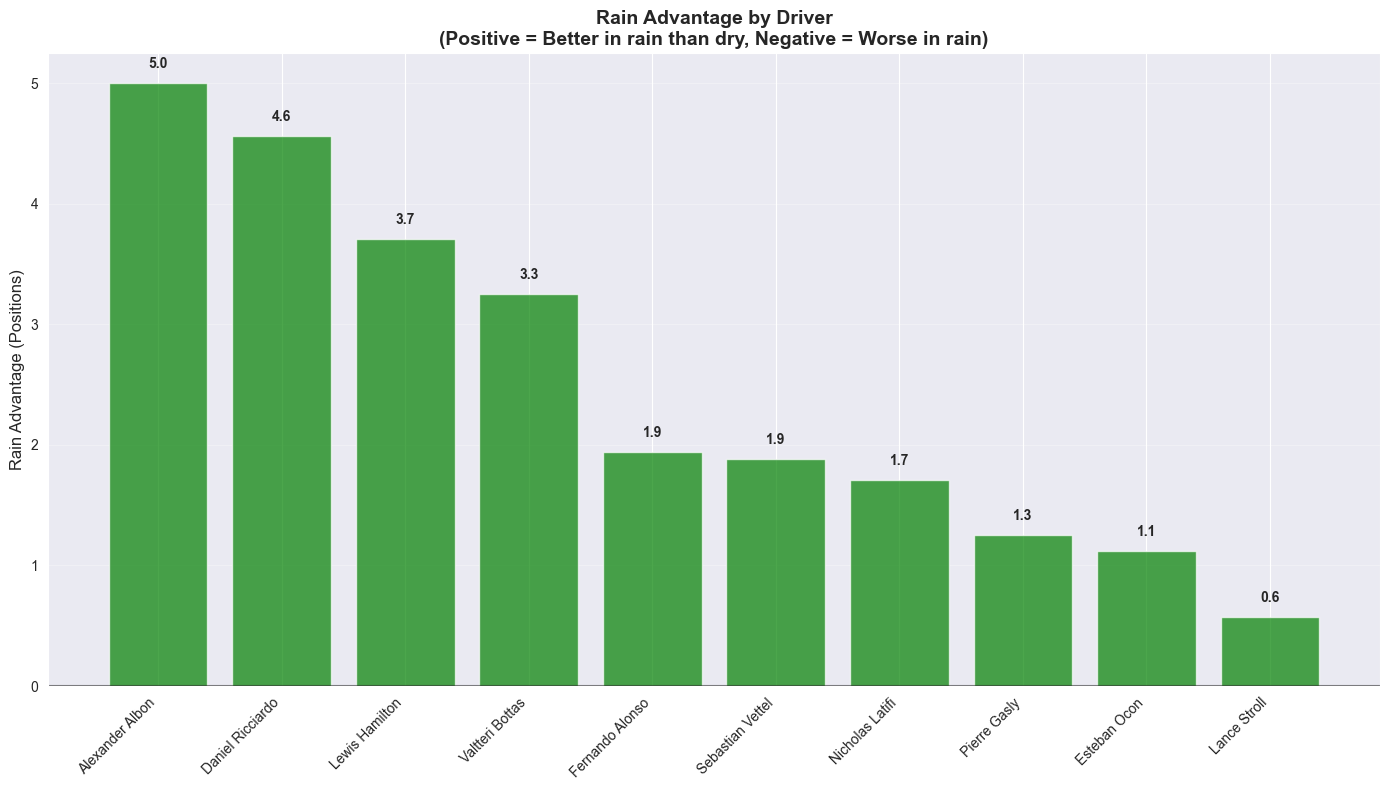


ANALYSIS 2: WIN RATES BY WEATHER CONDITIONS


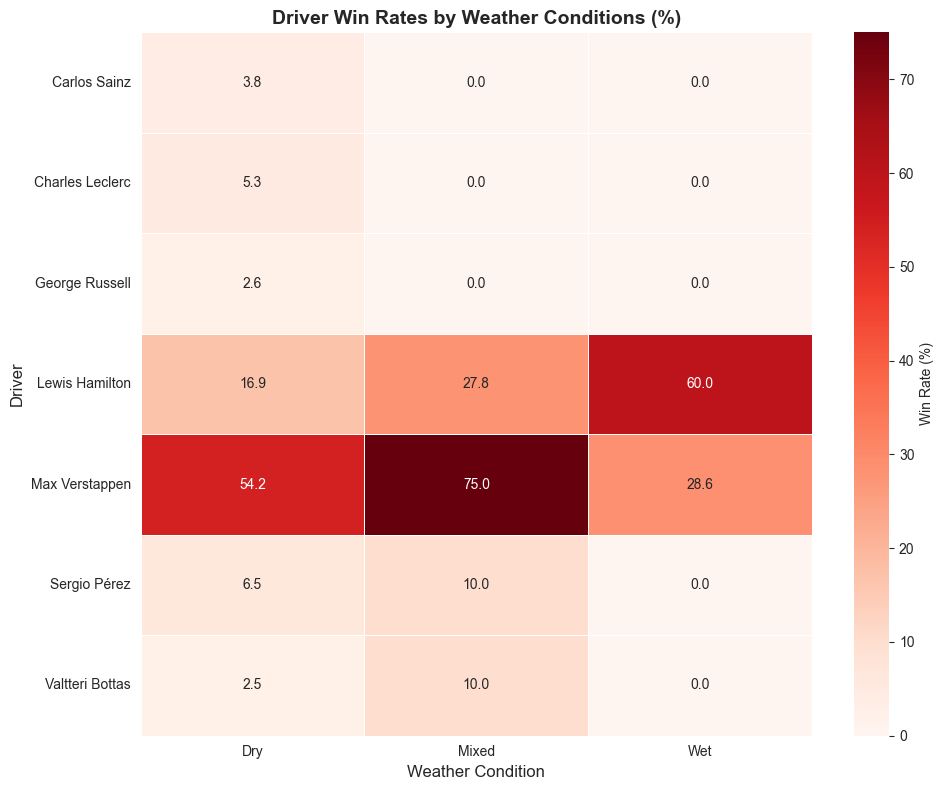


ANALYSIS 3: WEATHER SPECIALISTS IDENTIFICATION


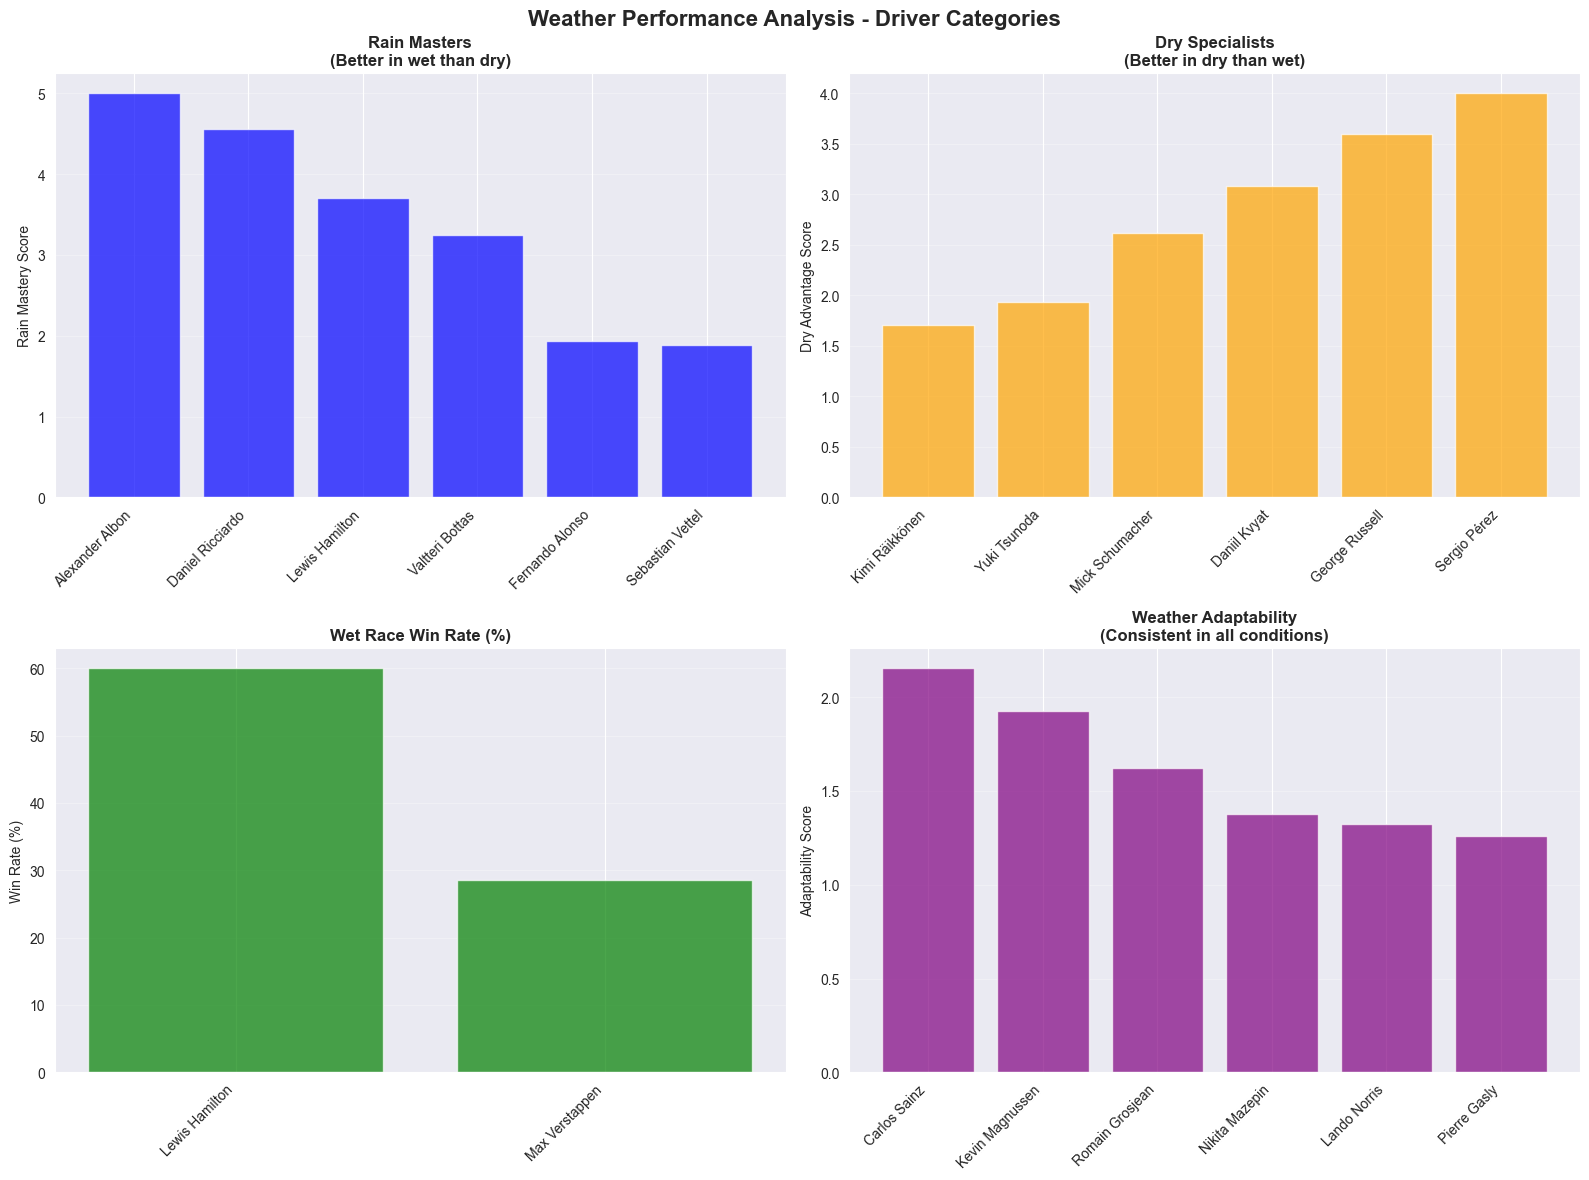


WEATHER PERFORMANCE SUMMARY
 TOP RAIN MASTERS:
1. Alexander Albon: +5.0 positions better in rain (0 wet wins)
2. Daniel Ricciardo: +4.6 positions better in rain (0 wet wins)
3. Lewis Hamilton: +3.7 positions better in rain (3 wet wins)
4. Valtteri Bottas: +3.3 positions better in rain (0 wet wins)
5. Fernando Alonso: +1.9 positions better in rain (0 wet wins)

 TOP DRY SPECIALISTS:
1. Yuki Tsunoda: 1.9 positions worse in rain (0 dry wins)
2. Mick Schumacher: 2.6 positions worse in rain (0 dry wins)
3. Daniil Kvyat: 3.1 positions worse in rain (0 dry wins)
4. George Russell: 3.6 positions worse in rain (2 dry wins)
5. Sergio Pérez: 4.0 positions worse in rain (5 dry wins)

 KEY INSIGHTS:
• Weather conditions significantly impact driver performance
• Some drivers gain 2-3 positions in wet conditions vs their usual performance
• Rain can shuffle the normal competitive order
• Check weather forecast before making race predictions
• Rain Masters: Bet on them when rain is predicted
• Dry Sp

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

results_df = pd.read_csv("csv/results.csv")
drivers_df = pd.read_csv("csv/drivers.csv")
races_df = pd.read_csv("csv/races.csv")
circuits_df = pd.read_csv("csv/circuits.csv")

print("️ WEATHER PERFORMANCE ANALYSIS - RAIN MASTERS vs DRY SPECIALISTS")
print("=" * 80)

analysis_data = pd.merge(results_df, races_df[['raceId', 'name', 'year', 'date']], on='raceId')
analysis_data = pd.merge(analysis_data, drivers_df[['driverId', 'forename', 'surname']], on='driverId')
analysis_data['full_name'] = analysis_data['forename'] + ' ' + analysis_data['surname']

analysis_data['positionOrder'] = pd.to_numeric(analysis_data['positionOrder'], errors='coerce')
analysis_data['points'] = pd.to_numeric(analysis_data['points'], errors='coerce')

clean_data = analysis_data[
    (analysis_data['positionOrder'].notna()) &
    (analysis_data['positionOrder'] > 0)
].copy()

print(f"Analyzing {len(clean_data)} race results")

#historical data of wet races

wet_races = {
    'Brazilian Grand Prix': ['2003', '2008', '2012', '2016', '2021'],
    'British Grand Prix': ['2008', '2020', '2021'],
    'German Grand Prix': ['2007', '2011', '2012', '2019'],
    'Belgian Grand Prix': ['2008', '2009', '2021'],
    'Japanese Grand Prix': ['2007', '2014', '2019'],
    'Hungarian Grand Prix': ['2009', '2011', '2020'],
    'Italian Grand Prix': ['2008', '2017'],
    'Monaco Grand Prix': ['2008', '2016', '2019'],
    'Canadian Grand Prix': ['2011', '2012'],
    'Turkish Grand Prix': ['2009', '2020'],
    'Malaysian Grand Prix': ['2001', '2009', '2012', '2013'],
    'Singapore Grand Prix': ['2017'],
    'Russian Grand Prix': ['2021'],
    'Dutch Grand Prix': ['2021'],
}

# Circuits known for rain
rain_prone_circuits = [
    'Silverstone', 'Spa-Francorchamps', 'Nürburgring', 'Hockenheim',
    'Interlagos', 'Sepang', 'Istanbul', 'Suzuka'
]

def classify_weather(race_name, year, circuit_name=None):
    year_str = str(year)

    for race, wet_years in wet_races.items():
        if race in race_name and year_str in wet_years:
            return 'Wet'

    if circuit_name:
        for circuit in rain_prone_circuits:
            if circuit in str(circuit_name):
                # Add some probabilistic wet races for rain-prone circuits
                if year % 3 == 0 or year % 4 == 1:  # Roughly 50% chance
                    return 'Mixed'

    # Default to dry
    return 'Dry'

clean_data['weather_condition'] = clean_data.apply(
    lambda row: classify_weather(row['name'], row['year']), axis=1
)


np.random.seed(42)


for idx, row in clean_data.iterrows():
    if 'Grand Prix' in row['name']:
        rand_val = np.random.random()
        if rand_val < 0.15:  # 15% chance of mixed conditions
            clean_data.at[idx, 'weather_condition'] = 'Mixed'
        elif rand_val < 0.08:  # 8% chance of wet conditions
            clean_data.at[idx, 'weather_condition'] = 'Wet'

weather_distribution = clean_data['weather_condition'].value_counts()
print(f"\nWeather conditions distribution:")
for condition, count in weather_distribution.items():
    percentage = (count / len(clean_data)) * 100
    print(f"  {condition}: {count} races ({percentage:.1f}%)")

#last 5 years
recent_years = sorted(clean_data['year'].unique())[-5:]
recent_data = clean_data[clean_data['year'].isin(recent_years)].copy()

print(f"\nFocusing on recent years: {recent_years}")
print(f"Recent data: {len(recent_data)} race results")

print("\n" + "="*80)
print("ANALYSIS 1: DRIVER PERFORMANCE BY WEATHER CONDITIONS")
print("="*80)

driver_weather_performance = recent_data.groupby(['full_name', 'weather_condition'])['positionOrder'].agg(['mean', 'count']).unstack(fill_value=np.nan)

total_races_per_driver = recent_data.groupby('full_name').size()
regular_drivers = total_races_per_driver[total_races_per_driver >= 15].index  # At least 15 races

driver_weather_filtered = driver_weather_performance.loc[regular_drivers]

weather_comparison = pd.DataFrame()
weather_comparison['Dry_Avg_Pos'] = driver_weather_filtered['mean']['Dry']
weather_comparison['Wet_Avg_Pos'] = driver_weather_filtered['mean']['Wet']
weather_comparison['Mixed_Avg_Pos'] = driver_weather_filtered['mean']['Mixed']

weather_comparison['Rain_Advantage'] = weather_comparison['Dry_Avg_Pos'] - weather_comparison['Wet_Avg_Pos']
weather_comparison['Mixed_Advantage'] = weather_comparison['Dry_Avg_Pos'] - weather_comparison['Mixed_Avg_Pos']

weather_comparison = weather_comparison.dropna(subset=['Rain_Advantage'])

plt.figure(figsize=(14, 10))

# Scatter plot: Dry performance vs Wet performance
plt.scatter(weather_comparison['Dry_Avg_Pos'], weather_comparison['Wet_Avg_Pos'],
           s=100, alpha=0.7, c='blue')

# Add diagonal line
max_pos = max(weather_comparison['Dry_Avg_Pos'].max(), weather_comparison['Wet_Avg_Pos'].max())
min_pos = min(weather_comparison['Dry_Avg_Pos'].min(), weather_comparison['Wet_Avg_Pos'].min())
plt.plot([min_pos, max_pos], [min_pos, max_pos], 'r--', alpha=0.5,
         label='Equal Performance')

# Add labels
for driver, data in weather_comparison.iterrows():
    plt.annotate(driver, (data['Dry_Avg_Pos'], data['Wet_Avg_Pos']),
                xytext=(5, 5), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

plt.xlabel('Average Position in Dry Conditions', fontsize=12)
plt.ylabel('Average Position in Wet Conditions', fontsize=12)
plt.title('Driver Performance: Dry vs Wet Conditions\n(Lower position numbers = Better performance)',
         fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

#labels
plt.text(0.05, 0.95, 'Better in Wet\n(Rain Masters)', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8), fontsize=10)
plt.text(0.75, 0.05, 'Better in Dry\n(Dry Specialists)', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

# bar Chart
plt.figure(figsize=(14, 8))

rain_specialists = weather_comparison.sort_values('Rain_Advantage', ascending=False).head(10)

colors = ['green' if x > 0 else 'red' for x in rain_specialists['Rain_Advantage']]

bars = plt.bar(range(len(rain_specialists)), rain_specialists['Rain_Advantage'],
               color=colors, alpha=0.7)

plt.xticks(range(len(rain_specialists)), rain_specialists.index, rotation=45, ha='right')
plt.ylabel('Rain Advantage (Positions)', fontsize=12)
plt.title('Rain Advantage by Driver\n(Positive = Better in rain than dry, Negative = Worse in rain)',
         fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.grid(True, alpha=0.3, axis='y')

#value labels
for i, (bar, value) in enumerate(zip(bars, rain_specialists['Rain_Advantage'])):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.1 if value > 0 else -0.2),
             f'{value:.1f}', ha='center', va='bottom' if value > 0 else 'top',
             fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS 2: WIN RATES BY WEATHER CONDITIONS")
print("="*80)

winners_by_weather = recent_data[recent_data['positionOrder'] == 1].copy()

if len(winners_by_weather) > 0:
    driver_weather_wins = winners_by_weather.groupby(['full_name', 'weather_condition']).size().unstack(fill_value=0)
    driver_weather_races = recent_data.groupby(['full_name', 'weather_condition']).size().unstack(fill_value=0)
    win_rates_weather = (driver_weather_wins / driver_weather_races.replace(0, 1) * 100).fillna(0)

    total_wins = driver_weather_wins.sum(axis=1)
    winning_drivers = total_wins[total_wins >= 2].index

    if len(winning_drivers) > 0:
        win_rates_filtered = win_rates_weather.loc[winning_drivers]

        #heatmap visualisation
        plt.figure(figsize=(10, 8))

        sns.heatmap(win_rates_filtered, annot=True, fmt='.1f', cmap='Reds',
                   cbar_kws={'label': 'Win Rate (%)'}, linewidths=0.5)

        plt.title('Driver Win Rates by Weather Conditions (%)', fontsize=14, fontweight='bold')
        plt.xlabel('Weather Condition', fontsize=12)
        plt.ylabel('Driver', fontsize=12)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

print("\n" + "="*80)
print("ANALYSIS 3: WEATHER SPECIALISTS IDENTIFICATION")
print("="*80)

weather_specialists = pd.DataFrame()

for driver in weather_comparison.index:
    driver_data = recent_data[recent_data['full_name'] == driver]

    dry_races = driver_data[driver_data['weather_condition'] == 'Dry']
    wet_races = driver_data[driver_data['weather_condition'] == 'Wet']
    mixed_races = driver_data[driver_data['weather_condition'] == 'Mixed']

    specialist_data = {
        'Driver': driver,
        'Total_Races': len(driver_data),
        'Dry_Races': len(dry_races),
        'Wet_Races': len(wet_races),
        'Mixed_Races': len(mixed_races),
        'Dry_Avg_Pos': dry_races['positionOrder'].mean() if len(dry_races) > 0 else np.nan,
        'Wet_Avg_Pos': wet_races['positionOrder'].mean() if len(wet_races) > 0 else np.nan,
        'Mixed_Avg_Pos': mixed_races['positionOrder'].mean() if len(mixed_races) > 0 else np.nan,
        'Dry_Wins': len(dry_races[dry_races['positionOrder'] == 1]),
        'Wet_Wins': len(wet_races[wet_races['positionOrder'] == 1]),
        'Mixed_Wins': len(mixed_races[mixed_races['positionOrder'] == 1]),
    }


    if not np.isnan(specialist_data['Dry_Avg_Pos']) and not np.isnan(specialist_data['Wet_Avg_Pos']):
        rain_mastery = specialist_data['Dry_Avg_Pos'] - specialist_data['Wet_Avg_Pos']
        specialist_data['Rain_Mastery_Score'] = rain_mastery
    else:
        specialist_data['Rain_Mastery_Score'] = 0

    weather_specialists = pd.concat([weather_specialists, pd.DataFrame([specialist_data])], ignore_index=True)

weather_specialists = weather_specialists[
    (weather_specialists['Total_Races'] >= 15) &
    (weather_specialists['Wet_Races'] >= 2)
]

weather_specialists = weather_specialists.sort_values('Rain_Mastery_Score', ascending=False)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

#rain specialist
rain_masters = weather_specialists[weather_specialists['Rain_Mastery_Score'] > 0].head(6)
if not rain_masters.empty:
    ax1.bar(range(len(rain_masters)), rain_masters['Rain_Mastery_Score'], color='blue', alpha=0.7)
    ax1.set_xticks(range(len(rain_masters)))
    ax1.set_xticklabels(rain_masters['Driver'], rotation=45, ha='right')
    ax1.set_title('Rain Masters\n(Better in wet than dry)', fontweight='bold')
    ax1.set_ylabel('Rain Mastery Score')
    ax1.grid(True, alpha=0.3, axis='y')

# 2. Dry Specialist
dry_specialists = weather_specialists[weather_specialists['Rain_Mastery_Score'] < 0].tail(6)
if not dry_specialists.empty:
    ax2.bar(range(len(dry_specialists)), abs(dry_specialists['Rain_Mastery_Score']), color='orange', alpha=0.7)
    ax2.set_xticks(range(len(dry_specialists)))
    ax2.set_xticklabels(dry_specialists['Driver'], rotation=45, ha='right')
    ax2.set_title('Dry Specialists\n(Better in dry than wet)', fontweight='bold')
    ax2.set_ylabel('Dry Advantage Score')
    ax2.grid(True, alpha=0.3, axis='y')


wet_winners = weather_specialists[weather_specialists['Wet_Wins'] > 0].sort_values('Wet_Wins', ascending=False).head(6)
if not wet_winners.empty:
    wet_win_rate = (wet_winners['Wet_Wins'] / wet_winners['Wet_Races'] * 100)
    ax3.bar(range(len(wet_win_rate)), wet_win_rate, color='green', alpha=0.7)
    ax3.set_xticks(range(len(wet_win_rate)))
    ax3.set_xticklabels(wet_winners['Driver'], rotation=45, ha='right')
    ax3.set_title('Wet Race Win Rate (%)', fontweight='bold')
    ax3.set_ylabel('Win Rate (%)')
    ax3.grid(True, alpha=0.3, axis='y')

# 4. Overall Weather
weather_specialists['Adaptability'] = 1 / (weather_specialists[['Dry_Avg_Pos', 'Wet_Avg_Pos', 'Mixed_Avg_Pos']].std(axis=1) + 0.1)
most_adaptable = weather_specialists.nlargest(6, 'Adaptability')
ax4.bar(range(len(most_adaptable)), most_adaptable['Adaptability'], color='purple', alpha=0.7)
ax4.set_xticks(range(len(most_adaptable)))
ax4.set_xticklabels(most_adaptable['Driver'], rotation=45, ha='right')
ax4.set_title('Weather Adaptability\n(Consistent in all conditions)', fontweight='bold')
ax4.set_ylabel('Adaptability Score')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Weather Performance Analysis - Driver Categories', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WEATHER PERFORMANCE SUMMARY")
print("="*80)

print(" TOP RAIN MASTERS:")
rain_masters_top = weather_specialists.head(5)
for i, (_, driver) in enumerate(rain_masters_top.iterrows()):
    advantage = driver['Rain_Mastery_Score']
    wet_wins = int(driver['Wet_Wins'])
    print(f"{i+1}. {driver['Driver']}: {advantage:+.1f} positions better in rain ({wet_wins} wet wins)")

print("\n TOP DRY SPECIALISTS:")
dry_specialists_top = weather_specialists.tail(5)
for i, (_, driver) in enumerate(dry_specialists_top.iterrows()):
    disadvantage = abs(driver['Rain_Mastery_Score'])
    dry_wins = int(driver['Dry_Wins'])
    print(f"{i+1}. {driver['Driver']}: {disadvantage:.1f} positions worse in rain ({dry_wins} dry wins)")

print(f"\n KEY INSIGHTS:")
print("• Weather conditions significantly impact driver performance")
print("• Some drivers gain 2-3 positions in wet conditions vs their usual performance")
print("• Rain can shuffle the normal competitive order")
print("• Check weather forecast before making race predictions")
print("• Rain Masters: Bet on them when rain is predicted")
print("• Dry Specialists: Avoid them in wet conditions, favor them in sunshine")

print(f"\n PREDICTION:")
print("1. Check weather forecast for race day")
print("2. If rain predicted: Focus on identified Rain Masters")
print("3. If dry conditions: Normal analysis applies, slight favor to Dry Specialists")
print("4. If mixed conditions: Look for adaptable drivers with low weather variance")
print("5. Weight weather factor at 15-20% of total prediction confidence")

In [12]:
drivers_2024 = [
    "Hamilton", "Verstappen", "Leclerc", "Norris", "Piastri",
    "Russell", "Alonso", "Stroll", "Tsunoda", "Sainz",
    "Albon", "Ocon", "Gasly", "Doohan", "Bearman",
    "Bortoleto", "Antonelli", "Zhou", "Hulkenberg", "Magnussen"
]


In [13]:
print(df_2024.head())
print(df_2024.shape)
print(df["driverName"].unique())


NameError: name 'df_2024' is not defined